# The best place to rent

Hill: A person visiting Manhattan can find the best neigbourhood for their needs without needing to do research

Using foursquare and travel time this project will group neighboorhods based on venues in that neighboorhod and venues in neighboorhods that are close in travel time

## Configure the notebook

- Load file with secrets
- Set some constants
- Load libraries

The API secrets are not pushed to github. This is handled by placing them in a file named secrets and removing version control from that file.
Since the file is not in the same directory as the notebooks extra code is needed to add the path to the sys search path

The secrets file containts two variables used in the Foursquare API: CLIENT_ID and CLIENT_SECRET
It contains two variables used int the travel time API: APP_ID and API_KEY

In [1]:
import os
project_folder_path = os.path.dirname(os.getcwd())
project_folder_path
import sys
sys.path.insert(0, project_folder_path)

import secrets
print('secrets.py imported')

secrets.py imported


The data path contains data loaded from the net. The sanbox accounts used to load the data have limits on the number of requests. Storing the results allows for restarting the kernal without having to make new calls to the API.

In [2]:
DATA_PATH = project_folder_path + '/data/external/'
print('Data path is :{}'.format(DATA_PATH))
del project_folder_path

Data path is :/Users/danielhaugstvedt/Developer/coursera_capstone/data/external/


Import the standard libraries

In [70]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
import json
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

import folium # map rendering library

import pickle # needed to store variables

import time # Try to not overload the traveltime API

from importnb import Notebook # Import notebooks

print('Libraries imported.')

Libraries imported.


## Get neighborhoods in New York which are not in Manhattan 

The dataset with neighborhoods for New York exists for free on the [web](https://geo.nyu.edu/catalog/nyu_2451_34572)

The information on the webpage where the download link is located gave this information for the element to download a geojson file
```
<a class="btn btn-primary btn-block download download-generated" 
   data-download-path="/download/nyu-2451-34572?type=geojson" 
    data-download="trigger" 
    data-download-type="geojson" 
    data-download-id="nyu-2451-34572" href="">Download
</a>
```

Using this information i ran a request. The information from running a request to the URI: `https://geo.nyu.edu/download/nyu-2451-34572?type=geojson` was:

`[['success',
  '<a data-download="trigger" data-download-id="nyu-2451-34572" data-download-type="generated-geojson" href="/download/file/nyu-2451-34572-geojson.json">Your file nyu-2451-34572-geojson.json is ready for download</a>']]`
  
I used this information to run the second request:

In [4]:
file_name = 'nyu-2451-34572-geojson.json'
URI_NY = 'https://geo.nyu.edu/download/file/nyu-2451-34572-geojson.json'

try: 
    print('Trying to open file: {}'.format(DATA_PATH + file_name))
    with open(DATA_PATH + file_name, 'r') as infile:
        ny_json = json.load(infile)
except FileNotFoundError:
    print('Failed to load json from local file, loading from web')
    response_ny = requests.get(URI_NY)
    print(response_ny.status_code, response_ny.reason)
    
    ny_json = response_ny.json()
    with open(DATA_PATH + file_name, 'w') as outfile:
        json.dump(ny_json, outfile)

print('Total number of features in geojsjon: {}'.format(ny_json['totalFeatures']))

Trying to open file: /Users/danielhaugstvedt/Developer/coursera_capstone/data/external/nyu-2451-34572-geojson.json
Total number of features in geojsjon: 306


Turn the json file into  a data frame

In [5]:
neighborhoods_data = ny_json['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods_ny = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods_ny = neighborhoods_ny.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [6]:
neighborhoods_ny.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Get some key information from the daframe

In [7]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods_ny['Borough'].unique()),
        neighborhoods_ny.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


Split the data in Manhattan and not Manhattan

If there are Neighborhoods with the same name we only keep the neigbourhood listed first. 
A second option would be to rename them but without local knowledge this would require researching. Removing 

In [8]:
neighborhoods_not_manhattan = (neighborhoods_ny.loc[neighborhoods_ny['Borough'] != 'Manhattan', 
                                                   ['Neighborhood', 'Latitude', 'Longitude']]
                                               .reset_index(drop=True)
                                               .drop_duplicates(subset = 'Neighborhood'))
neighborhoods_manhattan = (neighborhoods_ny.loc[neighborhoods_ny['Borough'] == 'Manhattan', 
                                               ['Neighborhood', 'Latitude', 'Longitude']]
                                           .reset_index(drop=True)
                                           .drop_duplicates(subset = 'Neighborhood'))

Print som key values from the data frames

In [9]:
print(('The number of neigborhoods in New York' 
       'but not in Manhattan is {}').format(len(neighborhoods_not_manhattan.index)))
print(('The number of neigborhoods in Manhattan is {}').format(len(neighborhoods_manhattan.index)))

The number of neigborhoods in New Yorkbut not in Manhattan is 264
The number of neigborhoods in Manhattan is 40


### Clean up the kernal

The notbook is so long that cleaning up while running it helps

In [10]:
del ny_json
del column_names
del data
del file_name
del neighborhoods_ny 
del neighborhood_lat     
del neighborhood_latlon  
del neighborhood_lon     
del neighborhood_name    
del neighborhoods_data    
del infile
del URI_NY
del borough
print('Cleaned')

Cleaned


## Get the foursquare data for nieghborhoods not in Manhattan

Using the foursquare API, get the venues in New York

In [11]:
neighborhood_latitude = neighborhoods_not_manhattan['Latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhoods_not_manhattan['Longitude'] # neighborhood longitude value
neighborhood_name = neighborhoods_not_manhattan['Neighborhood'] # neighborhood name

Set some global variables to use in the four square API


In [12]:
# We want the real number, not a relative number
# Thereforw we set the limit to be so high that there should never be any venues droped (this is tested)
LIMIT = 500 
VERSION = '20180605' 

Define a function for gettingt nearby venues

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            secrets.CLIENT_ID, 
            secrets.CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)

        results_object = requests.get(url)
        if results_object.status_code != 200:
            print('A request failed with status code: {} and reason: {}'.format(
                    results_object.status_code, 
                    results_object.reason))
            break
        
        results = results_object.json()["response"]['groups'][0]['items']
        print('{} has {} venues'.format(name, len(results)))
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    print('makeing a data frame and returning it ')
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Check for a file with the data Call the function for getting nearby venues

The distance used is calculated like this
- Average walking speed 5 km/h
- Converted to m/min this is 83.33
- A 5 min walk is **416 m**

In [14]:
radius = 416 # The four square limit parameter uses meters
file_name = 'ny_venues.json'
try:
    print('Trying to open file: {}'.format(DATA_PATH + file_name))
    with open(DATA_PATH + file_name, 'rb') as infile:
        ny_venues = pickle.load(infile)
        print('Sucess loading from file')
except FileNotFoundError:
    print('Failed to load json from local file, trying to load from web')
    ny_venues = getNearbyVenues(neighborhood_name, neighborhood_latitude, neighborhood_longitude, radius)
    with open(DATA_PATH + file_name, 'wb') as outfile:
        pickle.dump(ny_venues, outfile)

Trying to open file: /Users/danielhaugstvedt/Developer/coursera_capstone/data/external/ny_venues.json
Sucess loading from file


In [15]:
print(ny_venues.shape)
ny_venues.head()

(5193, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896521,-73.844680,Pharmacy
2,Wakefield,40.894705,-73.847201,Pitman Deli,40.894149,-73.845748,Food
3,Co-op City,40.874294,-73.829939,Capri II Pizza,40.876374,-73.829940,Pizza Place
4,Co-op City,40.874294,-73.829939,Sleepy's Co-Op City,40.872234,-73.828607,Mattress Store


### Limit the number of neigboorhods

First we limit the neighborhoods to those with atleast one result  from foursquare. If there are no venues in foursquare for the neighborhood it's unliekly to be a neighborhood of interest for people looking for a appartment in New&nbsp;York.

In the proof of concept the limit was 20 first neighborhoods. In the second step it was a 100. Now it is 262 which is the maximum (all neighborhoods outside of Manhattan)

We did not get all the venues from all the neigborhoods because the API is on a sandbox account
Therefore we need to check which Neighborhood so we can use them in the Travel Time API 

In [16]:
neighborhoods_tmp = pd.DataFrame({'Neighborhood': ny_venues.Neighborhood.unique()}) # make a dataframe with unique values
neighborhoods_foursquare = neighborhoods_not_manhattan.merge(neighborhoods_tmp, how = 'right', on = 'Neighborhood')

In [17]:
neighborhoods_foursquare.shape

(262, 3)

The cell underneath was only needed during the POC.
Now that all the data is used it could be removed. Refactoring code could be an option but the time it will take might now be worth it. The next step is moving some of the code into scripts and then it is refactored anyway.

In [18]:
n_neighborhoods = 262

neighborhoods_final = neighborhoods_foursquare.iloc[0:n_neighborhoods]

ny_venues_final = ny_venues.merge(
    pd.DataFrame({'Neighborhood': neighborhoods_final.Neighborhood}), 
    how = 'right', 
    on = 'Neighborhood')


In [19]:
print(neighborhoods_final.shape)
print(ny_venues_final.shape)

(262, 3)
(5193, 7)


### Store the values so that the travel time can run a a separate script

In [20]:
file_name = 'neighborhoods_final.p'
with open(DATA_PATH + file_name, 'wb') as outfile:
    pickle.dump(neighborhoods_final, outfile)

In [21]:
file_name = 'ny_venues_final.p'
with open(DATA_PATH + file_name, 'wb') as outfile:
    pickle.dump(ny_venues_final, outfile)

### Clean up the kernal

The notbook is so long that cleaning up while running it helps

In [22]:
del LIMIT
del VERSION
del file_name
del infile
del outfile 
del radius     
del neighborhoods_tmp  
del neighborhoods_not_manhattan     
del neighborhoods_manhattan    
del neighborhoods_foursquare    
del n_neighborhoods
del getNearbyVenues
del ny_venues
del neighborhood_latitude
del neighborhood_longitude
del neighborhood_name
print('Cleaned')

Cleaned


## Get the travel time between the different neighborhoods

Using the traveltime API, get the travel time between the different neighborhoods

This has been moved to a new notebook. The reason is that the API was returning too manu requests. This was handled by saving the results, add more code, wait for some time and run again. This means the code is ugly.

Refactoring would take too much time

In [23]:
with Notebook(): 
        import travel_time

secrets.py imported
Data path is :/Users/danielhaugstvedt/Developer/coursera_capstone/data/external/
Libraries imported.
We need less than 2000 locations. The number we are using is 262
Trying to open file: /Users/danielhaugstvedt/Developer/coursera_capstone/data/external/traveltime_0_149.p
Sucess loading from file
150
150
Trying to open file: /Users/danielhaugstvedt/Developer/coursera_capstone/data/external/traveltime_150_192.p
Sucess loading from file
43
43
Trying to open file: /Users/danielhaugstvedt/Developer/coursera_capstone/data/external/traveltime_193_260.p
Sucess loading from file
68
68
Trying to open file: /Users/danielhaugstvedt/Developer/coursera_capstone/data/external/traveltime_261.p
Sucess loading from file
1


In [24]:
travel_time_df = travel_time.travel_time_df

### Clean up the kernal

The notbook is so long that cleaning up while running it helps

In [25]:
del travel_time
print('Cleaned')

Cleaned


## Describe the neighborhoods using the pricipal components analysis

Tested approaches:

- Fit PCA to local venues first and extract the two pricipal components (PC). Use the same components on the venues that are weighted with travel

- Fit a separate PCA to both the local venues and the venues weighted with local venues (This is the one presented)

- Merge the data and run a PCA on the combined information

Untested:
- Sum the local and the venues that er weighted with travel. This has not been tested. This is becuse most of the value proposition is from telling a nerative. Beeing able to seperate the two factors seems really important.

### Prep the data

There are two datasets, the first is the local venues. It is made in to steps
- Make one hot encoding of the venues
- Sum the venues from each cite

The second dataset is the weighted sum of the venues from other neighborhoods. The weight is inverse proportional to the number of hurs

Make the local dataset

In [26]:
ny_onehot = pd.get_dummies(ny_venues_final[['Venue Category']], prefix="", prefix_sep="", dtype = 'float')
ny_onehot['Neighborhood'] = ny_venues_final['Neighborhood']
local_venues_df = ny_onehot.groupby('Neighborhood').agg('sum')

Make the travel dataset (weigted sum)
First #hours is converted to 1/#hours. A zero means that no public transport is available and the number should be infinite. This is handled after the division where infinite values are replaced with 0. This is not true for the travel from a Neighborhood to it self. However when caluclating the travel the weight on those should be zero.

This method is numerically unstable. Very short traveling times would result in really high values. It seems fair that a cofe shop half an hour away is weighted twice as high as a coffe shop an hour a way. However, should a coffeshop 10 minues away be weighted 6 times as high as a coffeshop an hour away? Probably. 

To increase stability, 0.1 hours could be added to all values. This is not needed in the POC becuse I check that no values are really big.

In [38]:
ones = (pd.DataFrame(index=travel_time_df.index, columns=travel_time_df.columns) # Data frame with NaNs
     .fillna(1))

travel_time_weights = ones.truediv(travel_time_df).replace(np.inf,0)


In [40]:
travel_time_weights.max().max()

13.284132841328413

The maximum weight reflect a traveling time of only four and a half minute. It seems reasonable to weight such a value quite high and as long as the interpretations make sence we keep it

In [41]:
travel_venues_df = travel_time_weights.dot(local_venues_df)  

In [42]:
print(local_venues_df.shape, travel_venues_df.shape, travel_time_df.shape)

(262, 353) (262, 353) (262, 262)


### Do PCA on the local venues dataset

In [44]:
# standarize the data
x = StandardScaler().fit_transform(local_venues_df.values) 

pca = PCA(n_components=2)
pca.fit(x)

# Get the PC of the local
principalComponents = pca.transform(x)
principalDf = pd.DataFrame(
    data = principalComponents, 
    columns = ['principal component 1', 'principal component 2'],
    index = local_venues_df.index)

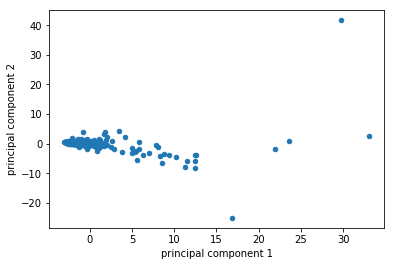

In [45]:
%matplotlib inline

principalDf.plot.scatter(x='principal component 1',y='principal component 2')

The four outliers really hurt the PCA. Removing them might make it easier to see how the other neighborhoods behave 

In [46]:
special_neighborhoods = principalDf.loc[principalDf['principal component 1']>15,:]
print(special_neighborhoods.index)
special_neighborhoods_df = local_venues_df.loc[special_neighborhoods.index,:]
special_neighborhoods_df.sum(axis=1)

Index(['Carroll Gardens', 'Downtown', 'Greenpoint', 'North Side',
       'South Side'],
      dtype='object', name='Neighborhood')


Neighborhood
Carroll Gardens     90.0
Downtown           100.0
Greenpoint         100.0
North Side         100.0
South Side         100.0
dtype: float64

They all have close to a 100 venues. 4 hava exactly a 100 venues. The later is due to the PAI and the sandbokx account.

Exluding them from the data (they could be used with the Manhattan data instead) should result in results that makes more sence

In [47]:
is_special = local_venues_df.index.isin(special_neighborhoods.index)
local_venues_clean_df = local_venues_df[~is_special]

In [48]:
# standarize the data
x_clean = StandardScaler().fit_transform(local_venues_clean_df.values) 

pca1 = PCA(n_components=2)
pca1.fit(x_clean)

# Get the PC of the local
principalComponents_clean = pca1.transform(x_clean)
principalDf_clean = pd.DataFrame(data = principalComponents_clean
             , columns = ['principal component 1', 'principal component 2'])

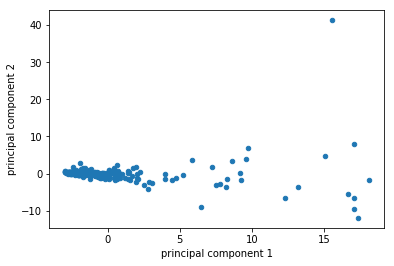

In [49]:
principalDf_clean.plot.scatter(x='principal component 1', y='principal component 2')

It looks better, There is one new outlier. Looking at the amount of variance explained tells us more.

In [50]:
print(('The two first principal components explain {:.1%} of '
      'the variance in the local data').format(
    sum(pca.explained_variance_ratio_)
    ))
print(('The two first principal components explain {:.1%} of '
      'the variance in the cleaned local data').format(
    sum(pca1.explained_variance_ratio_)
    ))

The two first principal components explain 9.6% of the variance in the local data
The two first principal components explain 7.8% of the variance in the cleaned local data


The PCA was not that sucessfull. The large number of zeros in the data and the high number of venu types makes this a problem where PCA seems to come up a bit short.

Switching to a simple count of the number of venues might be just as good as the PCA. 

**Attribute 1: Busy**

The first atribute is the total number of venues in the neighborhood. This variable will be names busy. It seems like a fair name and it is easy to understand. A transformation might be needed to give values that are easier to comunicate.

### Remove neighborhoods that are too busy

The four neighboorhoods that are taken out when the local data is cleaned should be taken out of the travel data and the location data 

In [51]:
is_special = travel_venues_df.index.isin(special_neighborhoods.index)
travel_venues_clean_df = travel_venues_df[~is_special]

In [52]:
is_special = neighborhoods_final.index.isin(special_neighborhoods.index)
neighborhoods_final_clean = neighborhoods_final[~is_special]

### Travel data PCA

The travel data is a weighted combination of the venues which you can get to with public transport.

The venues removed becouse they are super busy are included in the values. This means you are allowd to travel to them. They are excluded from the PCA. A neighborhood needs local information to be interesting

A possible imporvment is to also includ the venues from Manhattan. These are all super busy and the numbers are probably wrong as they have 100+ venues. Before improving the data we should explore what can be done with the current data. 



In [53]:
x_travel = StandardScaler().fit_transform(travel_venues_clean_df.values) 

pca2 = PCA(n_components=2)
pca2.fit(x_travel)

principalComponents_travel = pca2.transform(x_travel)
principalDf_travel = pd.DataFrame(
    data = principalComponents_travel, 
    columns = ['principal component 1', 'principal component 2'])

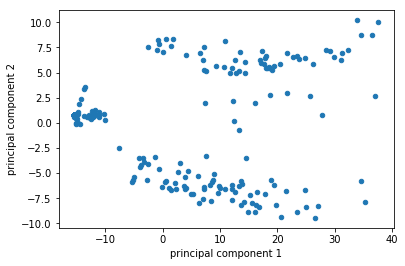

In [54]:
principalDf_travel.plot.scatter(x='principal component 1', y='principal component 2')

In [55]:
print(('The two first principal components explain {:.1%} % of '
      'the variance in the travel data').format(
    sum(pca2.explained_variance_ratio_ )
    ))

The two first principal components explain 79.1% % of the variance in the travel data


It looks like the PCA worked very well on the travel data. They could most likely be used to tell a story which will make sence to users. 

Also, it looks like there are three groups main groups. It could be possible to do some classificaiton on the data. (No need to do PCA first). However, reporting to users a number on a scale seems more interesting than just giving them which category the neighborhood is in.

### Understanding the PCs of the travel data

The final step is to check what the two components means

A histogram of the values in the principal component is a good start. We start with the first PC

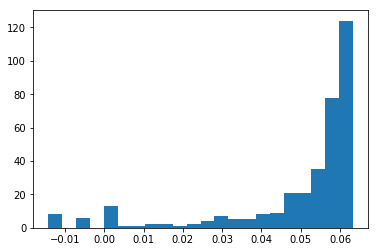

In [56]:
plt.hist(pca2.components_[0], bins='auto')  # arguments are passed to np.histogram
plt.show()

**Atribute 2: Connectivity**

The first PC from the travel dataset is names COnnectivity. Most of the values from component 1 are between 0.05 and 0.06. This means a high value for PC 1 is the same as having many venues reachable with public transport. 

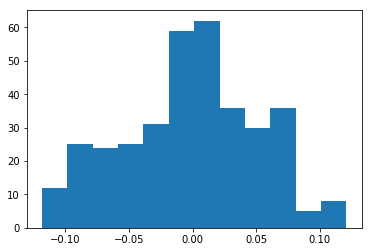

In [57]:
plt.hist(pca2.components_[1], bins='auto')  # arguments are passed to np.histogram
plt.show()

There are a continuum of values for PC 2. Looking at the once that are above 0.10 and below -0.5 might give some clue to what name should be used for the feature

In [63]:
travel_venues_clean_df.iloc[:, pca2.components_[1] > 0.05].columns

Index(['Airport Terminal', 'Arepa Restaurant', 'Automotive Shop', 'Baby Store',
       'Baseball Stadium', 'Beach', 'Beach Bar', 'Bed & Breakfast',
       'Board Shop', 'Boat or Ferry', 'Bridge', 'Burrito Place', 'Butcher',
       'Candy Store', 'Chocolate Shop', 'College Quad', 'Comic Shop',
       'Dim Sum Restaurant', 'Eastern European Restaurant',
       'Ethiopian Restaurant', 'Event Service', 'Farm', 'Field', 'Food Court',
       'Food Stand', 'Gaming Cafe', 'Garden', 'German Restaurant', 'Gift Shop',
       'Golf Course', 'Hardware Store', 'Hawaiian Restaurant',
       'History Museum', 'Hot Dog Joint', 'Irish Pub', 'Israeli Restaurant',
       'Jazz Club', 'Kebab Restaurant', 'Lingerie Store', 'Newsstand',
       'Other Great Outdoors', 'Other Nightlife', 'Other Repair Shop',
       'Outdoors & Recreation', 'Pakistani Restaurant', 'Photography Studio',
       'Pie Shop', 'Pier', 'Piercing Parlor', 'Pilates Studio', 'Print Shop',
       'Racetrack', 'Road', 'Russian Restaurant',

Looking at these i get a fealing of being in California. Even more than that I get the fealing of beeing outside a city center.  

In [62]:
travel_venues_clean_df.iloc[:, pca2.components_[1] < -0.05].columns

Index(['Accessories Store', 'Afghan Restaurant', 'African Restaurant',
       'Airport Tram', 'Art Museum', 'Baseball Field', 'Basketball Court',
       'Bath House', 'Bike Rental / Bike Share', 'Bistro', 'Bus Line',
       'Bus Station', 'Cantonese Restaurant', 'Check Cashing Service',
       'Comedy Club', 'Comfort Food Restaurant', 'Community Center',
       'Construction & Landscaping', 'Cupcake Shop', 'Discount Store',
       'Empanada Restaurant', 'Eye Doctor', 'Fish & Chips Shop', 'Fish Market',
       'Food', 'Frozen Yogurt Shop', 'Fruit & Vegetable Store',
       'Gymnastics Gym', 'Halal Restaurant', 'Hostel', 'Hotel', 'Hotel Pool',
       'Hotpot Restaurant', 'Hunan Restaurant', 'IT Services', 'Indie Theater',
       'Indonesian Restaurant', 'Intersection', 'Korean Restaurant',
       'Kosher Restaurant', 'Lake', 'Laundromat', 'Laundry Service', 'Lawyer',
       'Library', 'Malay Restaurant', 'Martial Arts Dojo', 'Medical Center',
       'Moroccan Restaurant', 'Noodle House',

Looking at these i get a feeling of being in New York. Even more than that I get the fealing of beeing inside a city center. 

**Atribute 3: Urban**

Transforming the PC2 by simply changing the sign it seems to fit the name urban. This makes it possible to havw some place urban but not busy which sounds cool.

### Clean up the kernal

The notbook is so long that cleaning up while running it helps

In [46]:
del pca
del pca1
del pca2
del ny_onehot
del ny_venues_final
del local_venues_df 
del neighborhoods_final
del principalComponents
del principalComponents_clean
del principalComponents_travel
del principalDf
del principalDf_clean
del travel_time_df
del travel_venues_clean_df
del travel_venues_df
del x
del x_clean
del x_travel
del special_neighborhoods
del special_neighborhoods_df

print('Cleaned')

Cleaned


## Add the three atributes to the venues

Busy, Urban and Connected are the tree atributes we will provide users with. 

Increasing accuracy of the features and adding new attributes are a long term goal but the need for Data Science is no longer pivotal to the progress. A front end whcih can be used etc. is needed to make a minimal viable product. When that is done, more effort should be put on improving the quality and the number of atributes.

One aspect that has to be done i a minimal viable product is to make the numbers more acaptable for humans.

The first atribute seems OK, but the second and third seem strange. What does value of 0.05 on the attribute urban mean?

Changing all the values to numbers from 0 to 10 makes it easier to understand. Urban: 8/10 makes sence. 

In [116]:
attribute_one = local_venues_clean_df.sum(axis = 1).to_frame()
attribute_one = np.sqrt(attribute_one)
#Collect the attributes from the principal components
attribute_two_three = principalDf_travel.copy()
attribute_two_three.index = attribute_one.index
attribute_two_three['principal component 2'] = -attribute_two_three['principal component 2']


attributes_tmp = pd.merge(attribute_one, attribute_two_three, 
                      how='inner', on='Neighborhood')

Now we scale the values and set the column names

In [117]:
attributes_matrix1 = MinMaxScaler(feature_range=(0, 10)).fit_transform(attributes_tmp.values)
attributes_matrix2 = np.floor(attributes_matrix1)
attributes = pd.DataFrame(attributes_matrix2, index = attributes_tmp.index, dtype=np.int8, columns = ['Busy', 'Connected', 'Urban'])

## Visualize the neighborhoods in a map 

Use the geocoding from travel time to get longetiude and altitude of Central Park in New York

Use the longitude and latitude to make a map of manhattan

Add labels for every neigbouthoods into the manhattan map

In [118]:
query = 'Murray Hill, New York'
URI_traveltime = 'HTTPS://api.traveltimeapp.com/v4/geocoding/search?query={}'.format(query)
print('URI is : {}'.format(URI_traveltime))
headers = {'Host': 'api.traveltimeapp.com',
           'Accept': 'application/json', 
           'X-Application-Id': secrets.APP_ID, # APP ID is in separate file not under version control
           'X-Api-Key': secrets.API_KEY} # API_KEY is in separate file not under version control
result = requests.get(URI_traveltime, headers=headers)
print(result.status_code, result.reason)

URI is : HTTPS://api.traveltimeapp.com/v4/geocoding/search?query=Murray Hill, New York
200 OK


In [119]:
new_york_location_data = result.json()['features'][0]
[longitude, latitude] = new_york_location_data['geometry']['coordinates']
print(longitude, latitude)

-73.979498 40.748085


In [120]:
def html_label(Name, value1, value2, value3):
    label = ('<table style="width:100%">'
                '<tr>'
                    '<th>{}</th>'
                    '<th></th>'
                '</tr>'
                '<tr>'
                    '<td>Busy:  </td>'
                    '<td align="right">{:}/10</td>'
                '</tr>'
                '<tr>'
                    '<td>Connected:  </td>'
                    '<td align="right">{:}/10</td>'
                '</tr>'
                    '<td>Urban:  </td>'
                    '<td align="right">{:}/10</td>'
                '</tr>'
            '</table>').format(Name, value1, value2, value3)
    
    return label

In [121]:
# create map of Manhattan using latitude and longitude values
# The pop ups only works at zoom 12 or higher
map_new_york = folium.Map(location=[latitude, longitude], zoom_start=11)

neighborhoods = neighborhoods_final_clean.loc[:, 'Neighborhood']
latitudes = neighborhoods_final_clean.loc[:, 'Latitude']
longitudes = neighborhoods_final_clean.loc[:, 'Longitude']
attribute_one = attributes.loc[:, 'Busy']
attribute_two = attributes.loc[:, 'Connected']
attribute_three = attributes.loc[:, 'Urban']

# add markers to map
for lat, lng, neighborhood, attr1, attr2, attr3 in zip(latitudes, longitudes, neighborhoods, 
                                                       attribute_one, attribute_two, attribute_three):
    label_html = html_label(neighborhood, attr1, attr2, attr3)
    label = folium.Popup( label_html, parse_html=False)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_new_york)  
map_new_york

## Include link to picture so that the results is viewable in Github

(www.linkhere.com)